# Applying ML to neurodevelopmental discorders detection

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from problem import get_cv
from problem import get_all_data
from problem import split_data

from download_data import fetch_fmri_time_series

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels

from nilearn.connectome import ConnectivityMeasure

## Loading the data

We start by downloading the data for both datasets

In [2]:
data, labels = get_all_data()

In [3]:
data.head()

,participants_site,participants_sex,participants_age,participants_dx,participants_dataset,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,...,fmri_basc197,fmri_basc325,fmri_basc444,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_msdl,fmri_power_2011,fmri_motions,fmri_select,repetition_time
subject_id,,,,,,,,,,,,,,,,,,,,,
adhd700021,204,F,11.17,1,adhd200,1124,743,2886,1535,589,...,data/fmri_adhd/basc197/adhd700021/run_1/adhd70...,data/fmri_adhd/basc325/adhd700021/run_1/adhd70...,data/fmri_adhd/basc444/adhd700021/run_1/adhd70...,data/fmri_adhd/craddock_scorr_mean/adhd700021/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd700021/run_1/adhd70002...,data/fmri_adhd/power_2011/adhd700021/run_1/adh...,data/fmri_adhd/motions/adhd700021/run_1/motion...,1,2.0
adhd242402,204,F,13.24,1,adhd200,1039,595,1966,1568,411,...,data/fmri_adhd/basc197/adhd242402/run_1/adhd24...,data/fmri_adhd/basc325/adhd242402/run_1/adhd24...,data/fmri_adhd/basc444/adhd242402/run_1/adhd24...,data/fmri_adhd/craddock_scorr_mean/adhd242402/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd242402/run_1/adhd24240...,data/fmri_adhd/power_2011/adhd242402/run_1/adh...,data/fmri_adhd/motions/adhd242402/run_1/motion...,1,2.0
adhd972340,204,F,13.75,0,adhd200,601,492,1554,1345,455,...,data/fmri_adhd/basc197/adhd972340/run_1/adhd97...,data/fmri_adhd/basc325/adhd972340/run_1/adhd97...,data/fmri_adhd/basc444/adhd972340/run_1/adhd97...,data/fmri_adhd/craddock_scorr_mean/adhd972340/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd972340/run_1/adhd97234...,data/fmri_adhd/power_2011/adhd972340/run_1/adh...,data/fmri_adhd/motions/adhd972340/run_1/motion...,1,2.0
adhd055645,204,F,11.18,0,adhd200,699,521,1773,1251,341,...,data/fmri_adhd/basc197/adhd055645/run_1/adhd05...,data/fmri_adhd/basc325/adhd055645/run_1/adhd05...,data/fmri_adhd/basc444/adhd055645/run_1/adhd05...,data/fmri_adhd/craddock_scorr_mean/adhd055645/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd055645/run_1/adhd05564...,data/fmri_adhd/power_2011/adhd055645/run_1/adh...,data/fmri_adhd/motions/adhd055645/run_1/motion...,1,2.0
adhd436785,204,F,11.41,1,adhd200,799,605,2564,1688,419,...,data/fmri_adhd/basc197/adhd436785/run_1/adhd43...,data/fmri_adhd/basc325/adhd436785/run_1/adhd43...,data/fmri_adhd/basc444/adhd436785/run_1/adhd43...,data/fmri_adhd/craddock_scorr_mean/adhd436785/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd436785/run_1/adhd43678...,data/fmri_adhd/power_2011/adhd436785/run_1/adh...,data/fmri_adhd/motions/adhd436785/run_1/motion...,1,2.0


In [4]:
print('Number of subjects in the dataset: {}'.format(labels.size))

Number of subjects in the dataset: 1671


In [5]:
data.participants_dataset.value_counts()

abide      1150
adhd200     521
Name: participants_dataset, dtype: int64

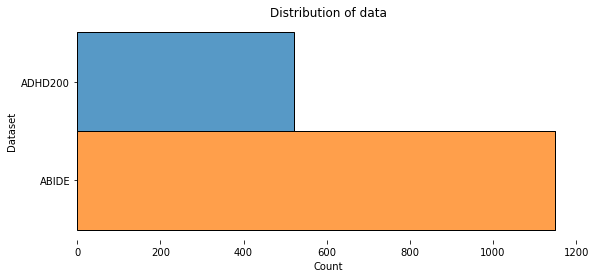

In [7]:
plt.figure(figsize=(9,4))
ax = sns.histplot(data, y="participants_dataset", hue = "participants_dataset",multiple="stack", legend = False)
ax.set(ylabel = "Dataset")
ax.set_yticklabels(['ADHD200','ABIDE'])
ax.set_title('Distribution of data')
sns.despine(bottom = True, left = True)
plt.show()

In [8]:
data.participants_dx.value_counts()

0    939
1    732
Name: participants_dx, dtype: int64

In [9]:
adhd = data[data['participants_dataset'] == 'adhd200']
adhd.participants_dx.value_counts()

0    338
1    183
Name: participants_dx, dtype: int64

In [10]:
abide = data[data['participants_dataset'] == 'abide']
abide.participants_dx.value_counts()

0    601
1    549
Name: participants_dx, dtype: int64

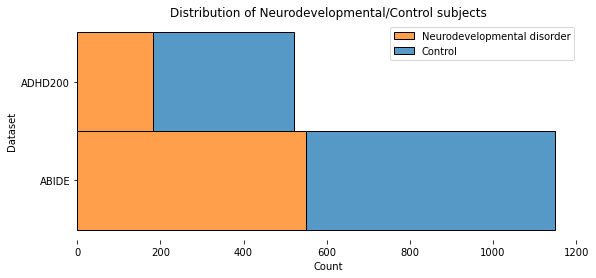

In [11]:
plt.figure(figsize=(9,4))
ax = sns.histplot(data, y="participants_dataset", hue = "participants_dx", multiple="stack")
ax.set(ylabel = "Dataset")
ax.set_yticklabels(['ADHD200','ABIDE'])
plt.legend(title='', loc='upper right', labels=['Neurodevelopmental disorder', 'Control'])
ax.set_title('Distribution of Neurodevelopmental/Control subjects')
sns.despine(bottom = True, left = True)
plt.show()

Splitting data to train and test

In [12]:
data_train, labels_train, data_test, labels_test = split_data(data, labels)

In [13]:
print('Number of subjects in the training tests: {}'.format(labels_train.size))

Number of subjects in the training tests: 1336


In [14]:
print('Number of subjects in the training tests: {}'.format(labels_test.size))

Number of subjects in the training tests: 335


## Participant features

In [15]:
data_train_participants = data_train[[col for col in data_train.columns if col.startswith('participants')]]
data_train_participants.head()

,participants_site,participants_sex,participants_age,participants_dx,participants_dataset
subject_id,,,,,
15680715926403849325,1,M,6.329911,0,abide
adhd499857,209,F,14.820000,0,adhd200
11423075398546923195,7,M,8.230000,1,abide
228103336523884890,19,M,19.000000,1,abide
adhd457366,208,M,11.000000,1,adhd200


## Structural MRI features

A set of structural features have been extracted for each subject: (i) normalized brain volume computed using subcortical segmentation of FreeSurfer and (ii) cortical thickness and area for right and left hemisphere of FreeSurfer.

In [16]:
data_train_anatomy = data_train[[col for col in data_train.columns if col.startswith('anatomy')]]
data_train_anatomy.head()

,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,...,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol.to.eTIV,anatomy_MaskVol.to.eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_select
subject_id,,,,,,,,,,,,,,,,,,,,,
15680715926403849325,930,563,2013,1666,600,3059,3958,3292,1050,5423,...,1250433,2217312,1.008560,1.509383,367,420,787,1.469019e+06,1.469019e+06,3
adhd499857,1087,720,1723,1470,500,3027,3918,3355,844,4271,...,897239,1406049,0.776706,1.049501,21,16,37,1.339731e+06,1.339731e+06,1
11423075398546923195,1576,643,2562,1371,426,2984,4440,3207,1193,4639,...,1109639,1671390,0.805873,1.065935,97,130,227,1.568003e+06,1.568003e+06,2
228103336523884890,1020,895,3262,1932,601,4051,5527,3780,1561,6503,...,1125314,1749907,0.778628,1.052128,56,44,100,1.663207e+06,1.663207e+06,1
adhd457366,1101,761,2231,1436,335,3606,5572,4105,1328,5370,...,1101543,1715241,0.787258,1.067242,155,138,293,1.607172e+06,1.607172e+06,1


Note that the column `anatomy_select` contain a label affected during a manual quality check (i.e. `0` and `3` reject, `1` accept, `2` accept with reserve). This column can be used during training to exclude noisy data for instance.

In [17]:
data_train_anatomy['anatomy_select'].head()

subject_id
15680715926403849325    3
adhd499857              1
11423075398546923195    2
228103336523884890      1
adhd457366              1
Name: anatomy_select, dtype: int64

## Functional MRI features

In [18]:
data_train_functional = data_train[[col for col in data_train.columns if col.startswith('fmri')]]
data_train_functional.head()

,fmri_basc064,fmri_basc122,fmri_basc197,fmri_basc325,fmri_basc444,fmri_craddock_scorr_mean,fmri_harvard_oxford_cort_prob_2mm,fmri_msdl,fmri_power_2011,fmri_motions,fmri_select
subject_id,,,,,,,,,,,
15680715926403849325,data/fmri/basc064/15680715926403849325/run_1/1...,data/fmri/basc122/15680715926403849325/run_1/1...,data/fmri/basc197/15680715926403849325/run_1/1...,data/fmri/basc325/15680715926403849325/run_1/1...,data/fmri/basc444/15680715926403849325/run_1/1...,data/fmri/craddock_scorr_mean/1568071592640384...,data/fmri/harvard_oxford_cort_prob_2mm/1568071...,data/fmri/msdl/15680715926403849325/run_1/1568...,data/fmri/power_2011/15680715926403849325/run_...,data/fmri/motions/15680715926403849325/run_1/m...,1
adhd499857,data/fmri_adhd/basc064/adhd499857/run_1/adhd49...,data/fmri_adhd/basc122/adhd499857/run_1/adhd49...,data/fmri_adhd/basc197/adhd499857/run_1/adhd49...,data/fmri_adhd/basc325/adhd499857/run_1/adhd49...,data/fmri_adhd/basc444/adhd499857/run_1/adhd49...,data/fmri_adhd/craddock_scorr_mean/adhd499857/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd499857/run_1/adhd49985...,data/fmri_adhd/power_2011/adhd499857/run_1/adh...,data/fmri_adhd/motions/adhd499857/run_1/motion...,1
11423075398546923195,data/fmri/basc064/11423075398546923195/run_1/1...,data/fmri/basc122/11423075398546923195/run_1/1...,data/fmri/basc197/11423075398546923195/run_1/1...,data/fmri/basc325/11423075398546923195/run_1/1...,data/fmri/basc444/11423075398546923195/run_1/1...,data/fmri/craddock_scorr_mean/1142307539854692...,data/fmri/harvard_oxford_cort_prob_2mm/1142307...,data/fmri/msdl/11423075398546923195/run_1/1142...,data/fmri/power_2011/11423075398546923195/run_...,data/fmri/motions/11423075398546923195/run_1/m...,1
228103336523884890,data/fmri/basc064/228103336523884890/run_1/228...,data/fmri/basc122/228103336523884890/run_1/228...,data/fmri/basc197/228103336523884890/run_1/228...,data/fmri/basc325/228103336523884890/run_1/228...,data/fmri/basc444/228103336523884890/run_1/228...,data/fmri/craddock_scorr_mean/2281033365238848...,data/fmri/harvard_oxford_cort_prob_2mm/2281033...,data/fmri/msdl/228103336523884890/run_1/228103...,data/fmri/power_2011/228103336523884890/run_1/...,data/fmri/motions/228103336523884890/run_1/mot...,1
adhd457366,data/fmri_adhd/basc064/adhd457366/run_1/adhd45...,data/fmri_adhd/basc122/adhd457366/run_1/adhd45...,data/fmri_adhd/basc197/adhd457366/run_1/adhd45...,data/fmri_adhd/basc325/adhd457366/run_1/adhd45...,data/fmri_adhd/basc444/adhd457366/run_1/adhd45...,data/fmri_adhd/craddock_scorr_mean/adhd457366/...,data/fmri_adhd/harvard_oxford_cort_prob_2mm/ad...,data/fmri_adhd/msdl/adhd457366/run_1/adhd45736...,data/fmri_adhd/power_2011/adhd457366/run_1/adh...,data/fmri_adhd/motions/adhd457366/run_1/motion...,1


Unlike the anatomical and participants data, the available data are filename to CSV files in which the time-series information are stored. We show in the next section how to read and extract meaningful information from those data.

Similarly to the anatomical data, the column `fmri_select` gives information about the manual quality check.

In [19]:
data_train_functional['fmri_select'].head()

subject_id
15680715926403849325    1
adhd499857              1
11423075398546923195    1
228103336523884890      1
adhd457366              1
Name: fmri_select, dtype: int64

## Evaluations functions 

The framework is evaluated with a cross-validation approach. The metrics used are the AUC under the ROC and the accuracy.

In [16]:
def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=('roc_auc', 'accuracy'), cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

## Using only anatomical features

#### FeatureExtractor

The available structural data can be used directly to make some classification. In this regard, we will use a feature extractor (i.e. `FeatureExtractor`). This extractor will only select only the anatomical features, dropping any information regarding the fMRI-based features.

In [17]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')

#### Classifier

We propose to use a logistic classifier preceded from a scaler which will remove the mean and standard deviation computed on the training set.

In [18]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(MinMaxScaler(), LogisticRegression())

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


We can test locally our pipeline using `evaluation` function that we defined earlier.

In [21]:
results_anat = evaluation(data, labels)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results_anat['train_roc_auc']),
                                                        np.std(results_anat['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results_anat['test_roc_auc']),
                                                          np.std(results_anat['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results_anat['train_accuracy']),
                                                         np.std(results_anat['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results_anat['test_accuracy']),
                                                           np.std(results_anat['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.784 +- 0.006
Validation score ROC-AUC: 0.680 +- 0.029 

Training score accuracy: 0.715 +- 0.004
Validation score accuracy: 0.639 +- 0.019


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


## fMRI-derived features

In [97]:
def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # make a transformer which will load the time series and compute the
        # connectome matrix
        self.transformer_fmri = make_pipeline(
            FunctionTransformer(func=_load_fmri, validate=False),
            ConnectivityMeasure(kind='tangent', vectorize=True))
        
    def fit(self, X_df, y):
        # get only the time series for the MSDL atlas
        fmri_filenames = X_df['fmri_msdl']
        self.transformer_fmri.fit(fmri_filenames, y)
        return self

    def transform(self, X_df):
        fmri_filenames = X_df['fmri_msdl']
        return self.transformer_fmri.transform(fmri_filenames)


In [98]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.))

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
       
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [100]:
results = evaluation(data, labels)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.599 +- 0.037 

Training score accuracy: 1.000 +- 0.001
Validation score accuracy: 0.584 +- 0.025


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.4min finished


## More elaborate pipeline: combining anatomy and fMRI

In [109]:
def _load_fmri(fmri_filenames):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return np.array([pd.read_csv(subject_filename,
                                 header=None).values
                     for subject_filename in fmri_filenames])


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # make a transformer which will load the time series and compute the
        # connectome matrix
        self.transformer_fmri = make_pipeline(
            FunctionTransformer(func=_load_fmri, validate=False),
            ConnectivityMeasure(kind='tangent', vectorize=True))
    
    def fit(self, X_df, y):
        fmri_filenames = X_df['fmri_msdl']
        self.transformer_fmri.fit(fmri_filenames, y)
        return self

    def transform(self, X_df):
        fmri_filenames = X_df['fmri_msdl']
        X_connectome = self.transformer_fmri.transform(fmri_filenames)
        X_connectome = pd.DataFrame(X_connectome, index=X_df.index)
        X_connectome.columns = ['connectome_{}'.format(i)
                                for i in range(X_connectome.columns.size)]
        # get the anatomical information
        X_anatomy = X_df[[col for col in X_df.columns
                          if col.startswith('anatomy')]]
        X_anatomy = X_anatomy.drop(columns='anatomy_select')
        # concatenate both matrices
        return pd.concat([X_connectome, X_anatomy], axis=1)


We will create a classifier (i.e. a random forest classifier) which will used both connectome and anatomical features.

In [110]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [111]:
results = evaluation(data, labels)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.678 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.627 +- 0.020


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.7min finished


We can propose a
more complex classifier than the previous one. We will train 2 single classifiers independetly on the sMRI-derived and fMRI-derived features. Then, a meta-classifier will be used to combine both information. We left out some data to be able to train the meta-classifier.

In [112]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf_connectome = make_pipeline(StandardScaler(),
                                            LogisticRegression(C=1.))
        self.clf_anatomy = make_pipeline(StandardScaler(),
                                         LogisticRegression(C=1.))
        self.meta_clf = LogisticRegression(C=1.)

    def fit(self, X, y):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]
        train_idx, validation_idx = train_test_split(range(y.size),
                                                     test_size=0.33,
                                                     shuffle=True,
                                                     random_state=42)
        X_anatomy_train = X_anatomy.iloc[train_idx]
        X_anatomy_validation = X_anatomy.iloc[validation_idx]
        X_connectome_train = X_connectome.iloc[train_idx]
        X_connectome_validation = X_connectome.iloc[validation_idx]
        y_train = y[train_idx]
        y_validation = y[validation_idx]

        self.clf_connectome.fit(X_connectome_train, y_train)
        self.clf_anatomy.fit(X_anatomy_train, y_train)

        y_connectome_pred = self.clf_connectome.predict_proba(
            X_connectome_validation)
        y_anatomy_pred = self.clf_anatomy.predict_proba(
            X_anatomy_validation)

        self.meta_clf.fit(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1),
            y_validation)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]

        y_anatomy_pred = self.clf_anatomy.predict_proba(X_anatomy)
        y_connectome_pred = self.clf_connectome.predict_proba(X_connectome)

        return self.meta_clf.predict(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1))

    def predict_proba(self, X):
        X_anatomy = X[[col for col in X.columns if col.startswith('anatomy')]]
        X_connectome = X[[col for col in X.columns
                          if col.startswith('connectome')]]

        y_anatomy_pred = self.clf_anatomy.predict_proba(X_anatomy)
        y_connectome_pred = self.clf_connectome.predict_proba(X_connectome)

        return self.meta_clf.predict_proba(
            np.concatenate([y_connectome_pred, y_anatomy_pred], axis=1))


In [113]:
results = evaluation(data, labels)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training score ROC-AUC: 0.890 +- 0.024
Validation score ROC-AUC: 0.660 +- 0.046 

Training score accuracy: 0.806 +- 0.037
Validation score accuracy: 0.618 +- 0.025


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min finished
